In [42]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import csv
import pandas as pd

import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
from matplotlib import pyplot as plt

In [31]:
## CNA sample article urls
# url = "https://www.channelnewsasia.com/sustainability/scientists-discover-how-air-pollution-triggers-lung-cancer-2931111"
# url = "https://www.channelnewsasia.com/asia/indonesia-subsidised-fuel-price-increase-micro-businesses-2929006"
url = "https://www.channelnewsasia.com/singapore/nightclub-operator-club-posh-west-palace-entertainment-evade-gst-money-laundering-jailed-penalty-2935436"
# url = "https://cnaluxury.channelnewsasia.com/people/chye-seng-huat-hardware-leon-foo-morning-coffee-machine-206531"

In [32]:
## convert CNA url -> HTML -> CSV
def extract_csv_from_html(url):
    try:
        page=requests.get(url) 
    except Exception as e:    
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                     
        print (error_type, 'Line:', error_info.tb_lineno)

    time.sleep(2)
    soup = BeautifulSoup(page.text, "html.parser")


    ## extract article content
    textContent = soup.find_all('div', attrs={'class':'text'})
    paragraphs = []

    for i in textContent:
        para = i.find_all('p')
        for j in para:
            content = j.getText().strip()
            paragraphs.append(content)

    df = pd.DataFrame(paragraphs)
    df.to_csv("backend/data/news.csv", index=False)


message = extract_csv_from_html(url)

In [ ]:
## convert cna url -> html -> txt
def extract_txt_from_html(url):
    try:
        page=requests.get(url) 
    except Exception as e:    
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                     
        print (error_type, 'Line:', error_info.tb_lineno)

    time.sleep(2)
    soup = BeautifulSoup(page.text, "html.parser")

    ## extract article title
    title = soup.find('h1',attrs={'class':'h1 h1--page-title'}).getText()

    ## extract article content
    textContent = soup.find_all('div', attrs={'class':'text'})
    paragraphs = []

    for i in textContent:
        para = i.find_all('p')
        for j in para:
            content = j.getText().strip()
            paragraphs.append(content)

    single_para = "".join(paragraphs)
    lines = "\n".join(paragraphs)
    multi_para = "\n".join(paragraphs)

    f = open("article.txt", "w+")
    f.write("Title: ")
    f.write(title)
    f.write("\nArticle Text:\n\n")
    f.write(multi_para)
    f.close()

message = extract_txt_from_html(url)

In [4]:
# extracts content from csv/txt in /data to an entire paragraph
def extract_text(filename):
    message = ""
    if (filename[-4:]) == ".csv":   # csv format
        with open("backend/data/{}".format(filename), 'r', encoding="utf8") as f:
            reader = csv.reader(f)
            next(reader, None)  # skip headers
            for row in reader:
                # print(row)    
                message += "".join(row)
            # print(sentences)
    elif (filename[-4:] == ".txt"):     # txt format
        with open("backend/data/{}".format(filename), 'r',  encoding="utf8") as f:
            message = "".join(f.readlines())
    return message

# split text > max_length into a list of sentences
def form_text_chunks(document, max_length):
    chunks = []
    sent = ""
    length = 0
    for sentence in document:
        # print(sentence + "\n")
        sentence +=  "."
        length += len(sentence)
        if length < max_length:
            sent += sentence
        else:
            # print(sent + "\n\n")
            chunks.append(sent)
            sent = ""
            length = 0
    if sent:
        chunks.append(sent)
    return chunks
    
# summarize text
def summarize(summarizer, chunks):
    result = ""
    for i in chunks:
        summarized = summarizer(i, max_length=70, min_length=30, do_sample=False)
        # print(summarized[0]["summary_text"])
        result += summarized[0]["summary_text"]
    # print(result)
    return result

def generate_summary(summarizer, filename):
    message = extract_text(filename)
    sentences = message.split('.')
    chunks = form_text_chunks(sentences, 1024)
    # print("chunks:", chunks)
    result = summarize(summarizer, chunks)
    # print(result + "\n")
    while (len(result) > 1200):
        sentences = result.split('.')
        chunks = form_text_chunks(sentences, 1024)
        result = summarize(summarizer, chunks)
    print(result)
    return result
    
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")
text = generate_summary(summarizer, "sample_news.csv")
# text = generate_summary(summarizer, "summarized.txt")


Your max_length is set to 70, but you input_length is only 61. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Air pollution has long been thought to be linked to a higher risk of lung cancer in people who have never smoked. Scientists say they have identified the mechanism through which air pollution triggers lung cancer. The research has sparked fresh calls for more urgent action to combat climate change.Previous research has shown that the DNA mutations can be present without causing cancer - and that most environmental carcinogens do not cause the mutations. But Swanton's study proposes a different model.When a cell is exposed to pollution it can trigger a "wound-healing response" that causes inflammation. And if that cell "harbours a mutation, it will then form a cancer""This opens a huge door, both for knowledge but also for new ways to prevent" cancer from developing, says Delaloge. Swanton calls air pollution a "hidden killer", pointing to research estimating it is linked to the deaths of more than eight million people a year."Given that probably five times as many people are exposed to

In [52]:
def generate_sentiments(message, model):
    message = message.replace('\n', ' ')
    texts = message.split('.')
    # print(texts, "\n\n")
    chunks = form_text_chunks(texts, 512)
    new_df = pd.DataFrame(columns=["Content","Sentiment", "Score"])

    for index in range(len(chunks)):
        preds = model(chunks[index])
        # print(preds)
        pred_sentiment = preds[0]["label"]
        pred_score = preds[0]["score"]

        # write predicted data into df
        new_df.at[index, "Sentiment"] = pred_sentiment
        new_df.at[index, "Score"] = pred_score
        # write text
        new_df.at[index, "Content"] = "".join((chunks[index]))

    # new_df.to_csv("backend/data/results.csv", index=False)
    new_df.to_json("backend/data/results.json")
    results = new_df
    return results

def predict(filename):
    message = extract_text(filename)
    # print(message)
    results = generate_sentiments(message, nlp)
    return results

model = "siebert/sentiment-roberta-large-english"
nlp = pipeline("sentiment-analysis", model=model, tokenizer=model)
results = predict("news.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/news.csv'

Sentiment
NEGATIVE    4
POSITIVE    1
dtype: int64


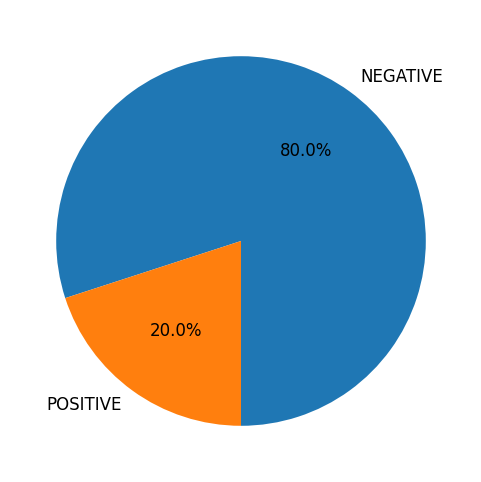

In [50]:
def generate_wordcloud(results):    
    # visualize the sentiments
    sentiment_counts = results.groupby(['Sentiment']).size()
    print(sentiment_counts)
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = plt.subplot(111)
    sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

generate_wordcloud(results)